**PHYS 139 Final Project:** attempting to recreate results from "Introducing the DREAMS Project: DaRk mattEr and Astrophysics with Machine Learning and Simulations" paper

**Goals:** to recreate the results from Section 4.2: "Inference with Convolutional Neural Networks"

In [1]:
## importing common packages
import numpy as np
import matplotlib.pyplot as plt
import scipy
import sys, os, time, optuna
import sklearn as sk

C:\Users\steph\miniconda3\envs\stephconda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
## defining global plotting parameters (can adjust as needed)

from matplotlib.colors import LogNorm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import gridspec

plt.rcParams.update(plt.rcParamsDefault)  # Reset the default matplotlib settings

plt.rcParams['figure.figsize'] = (5, 4)  # Set the figure size (width, height) in inches

plt.rcParams['font.size'] = 12  # Set the font size for labels and titles
plt.rcParams['figure.dpi'] = 150  # Set the DPI (dots per inch) for high-resolution output
plt.rcParams['font.family'] = 'serif'  # Set the font family

plt.rcParams['axes.linewidth'] = 1.5  # Set the linewidth of the axes
plt.rcParams['axes.edgecolor'] = 'black'  # Set the color of the axes' edges
plt.rcParams['axes.spines.top'] = True  # Hide the top spine of the axes
plt.rcParams['axes.spines.right'] = True  # Hide the right spine of the axes

plt.rcParams['xtick.direction'] = 'in'  # Set the direction of x-axis ticks to inward
plt.rcParams['xtick.major.size'] = 4  # Set the size of major x-axis ticks
plt.rcParams['xtick.major.width'] = 1.2  # Set the width of major x-axis ticks
plt.rcParams['xtick.minor.size'] = 2  # Set the size of minor x-axis ticks
plt.rcParams['xtick.minor.width'] = 1.0  # Set the width of minor x-axis ticks

plt.rcParams['ytick.direction'] = 'in'  # Set the direction of y-axis ticks to inward
plt.rcParams['ytick.right'] = True  # Show the y-ticks on the right axis
plt.rcParams['ytick.major.size'] = 4  # Set the size of major y-axis ticks
plt.rcParams['ytick.major.width'] = 1.2  # Set the width of major y-axis ticks
plt.rcParams['ytick.minor.size'] = 2  # Set the size of minor y-axis ticks
plt.rcParams['ytick.minor.width'] = 1.0  # Set the width of minor y-axis ticks

plt.rcParams['lines.linewidth'] = 1.5  # Set the linewidth of the plotted lines
plt.rcParams['legend.frameon'] = False  # Hide the frame of the legend
plt.rcParams['legend.fontsize'] = 10  # Set the font size of the legend

## Loading in the images and playing around with them:
**Parameter Names and Meanings:**

* omegaM = matter density parameter, representing the fraction of the Universe's total energy density contributed by all matter. This is measured as a ratio of the Universe's mean matter density to the critical density (the density required to make the Universe spatially flat). Most measurements place the value at about 0.27. If omegaM > 1, the Universe has a closed geometry (will eventually collapse). If omegaM < 1, the Universe has an open geometry (will keep expanding forever). If omegaM = 1, the Universe has a perfectly flat geometry (expansion will slow but still never stop completely).

* sigma8 = cosmological constant that quantifies the amplitude of matter density fluctuations on a scale of 8 megaparsecs / (
Mpc). It is used to measure the "clumpiness" of the universe, representing how much matter has clustered together into structures like galaxies and galaxy clusters. Measurements from the early universe suggest a higher degree of clumpiness (a higher sigma8 value), while measurements of nearby galaxies and clusters indicate a lower level of clumpiness (a lower sigma8 value).

* SNe = parameter that controls the strength of supernova explosions in the TNG simulations. This has a major effect on gas density, dark matter density, etc, so it should be mentioned and included.

* SNv = parameter that controls the strength of supernova wind velocity in the TNG simulations. This also has a major effect on gas density, dark matter density, etc, so it should be mentioned and included

* AGN = parameter that controls the strength of active galactic nucleus (typically supermassive black hole) feedback in the TNG simulations. This also has a major effect on gas density, dark matter density, etc, so it should be mentioned and included.

* 1/m_WDM = 1 over the WDM particle mass, expressed often in keV or simply in this form.

In [3]:
raw_images = np.load('Images_Nbody_WDM_TNG_z=0.00.npy', mmap_mode = "r+")
print(raw_images.shape)

(15000, 256, 256)


(1000, 6)


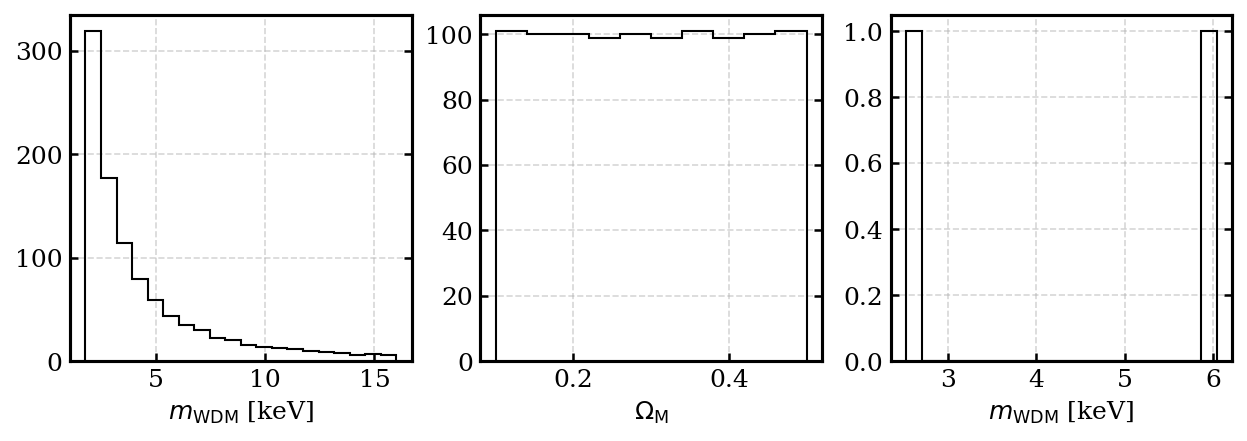

In [4]:
## recreating the 3 plots in the "data_play_around" notebook:
fig, ax = plt.subplots(ncols = 3, nrows = 1, figsize = (10,3))

## plot 1:
bins = 20

WDM_params_test = np.loadtxt('WDM_TNG_params_1000.txt')
print(WDM_params_test.shape)
WDM_param_names = ['OmegaM','sigma8','SNE','SNv','AGN','1/m_WDM']
minimum = np.array([0.1,  0.6,  0.25,   0.5,    0.25, 0.0625])
maximum = np.array([0.5,  1.0,  4.00,   2.00,   4.00, 0.5555])
WDM_params_test = (WDM_params_test * (maximum - minimum)) + minimum
ax[0].hist((1./WDM_params_test[:, 5]), bins=bins, color='k', histtype='step', lw=3, density=False, log=False) # plot a histogram of the WDM masses, log scale histogram
ax[0].grid(True, ls='--', alpha=0.5, which='both')
ax[0].set_xlabel(r'$m_{\rm WDM}$ [keV]')

## plot 2:
ax[1].hist(WDM_params_test[:, 0], bins=10, color='k', histtype='step', lw=3, density=False, log=False)
ax[1].grid(True, ls='--', alpha=0.5, which='both')
ax[1].set_xlabel(r'$\Omega_{\rm M}$')

## plot 3:
epsilon = 0.005
OmegaM_range = [0.49-epsilon,0.49+epsilon]
sigma8_range = [0.8-4*epsilon,0.8+4*epsilon]
WDM_masses_test = (1./WDM_params_test[:, 5])[(WDM_params_test[:, 0] > OmegaM_range[0]) & (WDM_params_test[:, 0] < OmegaM_range[1]) & (WDM_params_test[:, 1] > sigma8_range[0]) & (WDM_params_test[:, 1] < sigma8_range[1])]

ax[2].hist(WDM_masses_test, bins=bins, color='k', histtype='step', lw=3, density=False, log=False)
ax[2].grid(True, ls='--', alpha=0.5, which='both')
ax[2].set_xlabel(r'$m_{\rm WDM}$ [keV]')

plt.show()

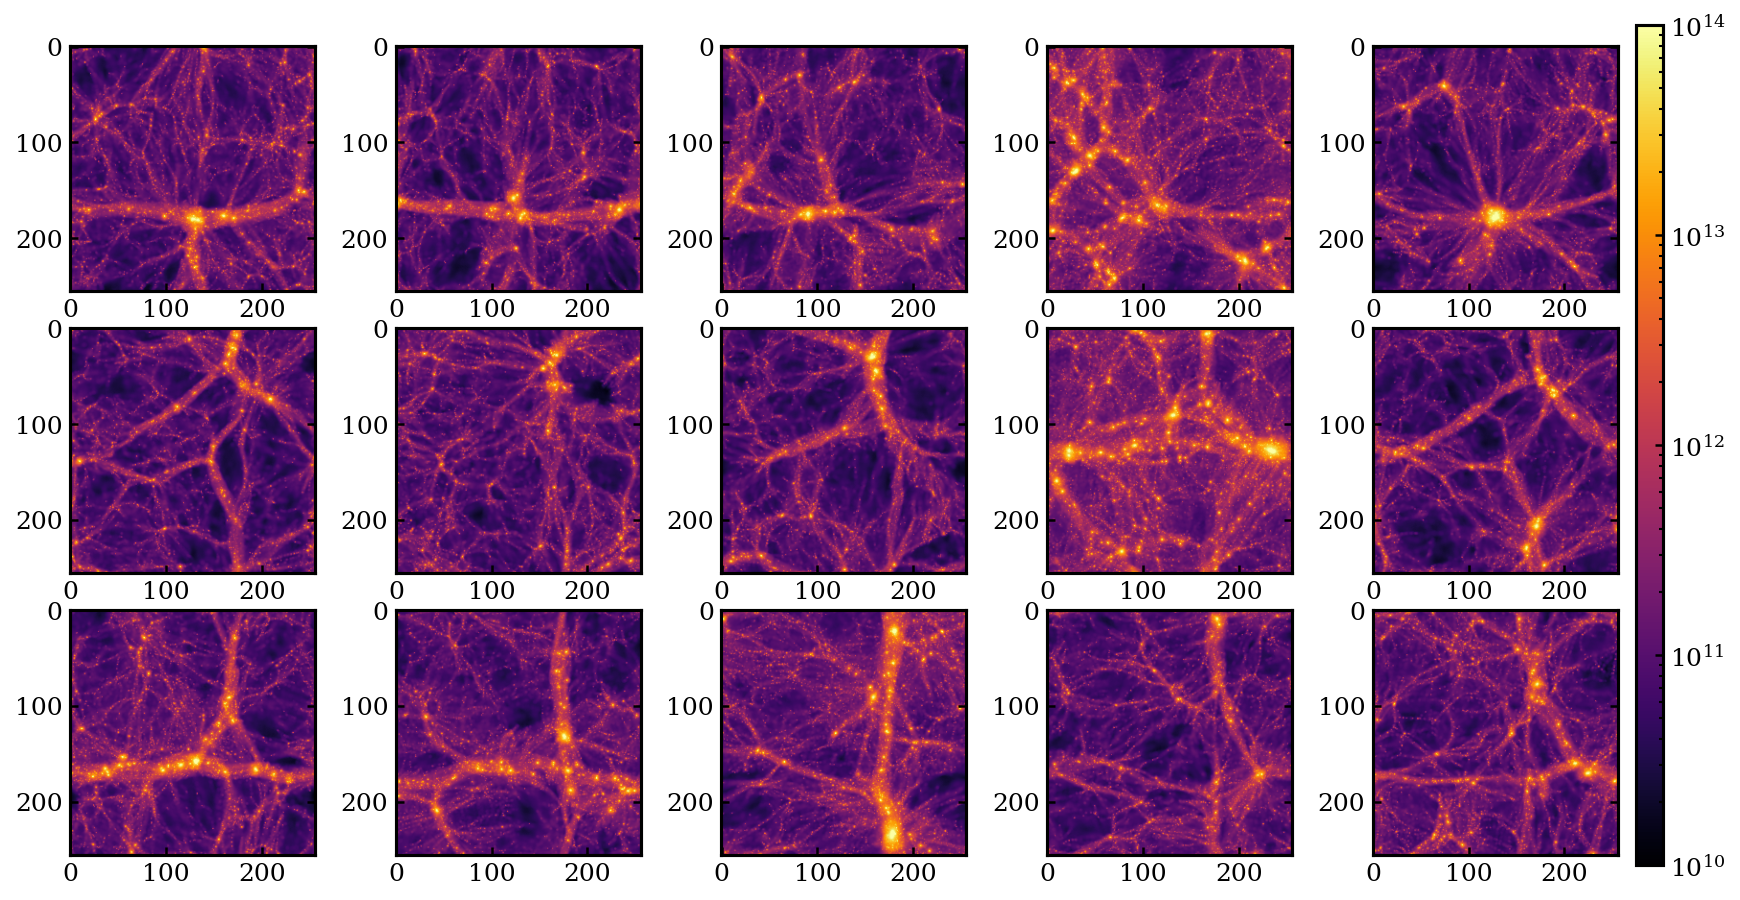

In [5]:
# visualise the first raw image, using log scale
mass_index = 5
epsilon = 0.005
omegam_mean = 0.49
sigma8_mean = 0.8
OmegaM_range = [omegam_mean-epsilon,omegam_mean+epsilon]
sigma8_range = [sigma8_mean-4*epsilon,sigma8_mean+4*epsilon]

valid_indices = ((WDM_params_test[:, 0] > OmegaM_range[0]) & (WDM_params_test[:, 0] < OmegaM_range[1]) & (WDM_params_test[:, 1] > sigma8_range[0]) & (WDM_params_test[:, 1] < sigma8_range[1]))

# finding the nth largest value in an array
index = np.argsort(WDM_params_test[:,mass_index])[-1]
error = 5e-1
target = 6 # keV
#index = np.where((WDM_params[:,mass_index] >= 1./(target + error)) & (WDM_params[:,mass_index] <= 1./(target - error)) & valid_indices)[0][0]
index = 0
#print(index)
vmin = 1e10; vmax = 1e14
#print(f'Params: {WDM_params[index]}')

## PLOT ONLY ONE PLOT:
#fig, axs = plt.subplots(figsize=(4,4), constrained_layout = True)
#print(f'WDM mass: {1./WDM_params[index][mass_index]} keV, OmegaM: {WDM_params[index][np.where(np.array(WDM_param_names) == "OmegaM")[0][0]]}, Sigma8: {WDM_params[index][np.where(np.array(WDM_param_names) == "sigma8")[0][0]]}')
#im = axs.imshow(raw_images[15*index + 3], norm=LogNorm(vmin=1e10, vmax=1e14), cmap='inferno')
#divider = make_axes_locatable(axs)
#cax = divider.append_axes("right", size="5%", pad=0.05)
#fig.colorbar(im, cax = cax)
#plt.show()

## LOOPING THROUGH FIRST 15 PLOTS:
fig, axes = plt.subplots(ncols = 5, nrows = 3, figsize=(14,7))
#plt.title(f'WDM mass: {1./WDM_params[index][mass_index]} eV')
for i, ax in enumerate(axes.flat):
    im = ax.imshow(raw_images[15*index + i], norm=LogNorm(vmin=vmin, vmax=vmax), cmap='inferno')

fig.subplots_adjust(wspace = 0.0025, hspace = 0.15)
cax = fig.add_axes([0.89, 0.1, 0.0125, 0.8])
fig.colorbar(im, cax=cax)
#plt.savefig("added_colorbar.png")
plt.show()

## Data Preprocessing:

In [6]:
## data stored as 15,000 individual elements in a numpy array
## each simulation is stored as 15 slices along some axis

raw_images = np.load('Images_Nbody_WDM_TNG_z=0.00.npy', mmap_mode = "r+")
print(f"RAW IMAGE DATA SHAPE: {raw_images.shape}")

fixed_raw_images = raw_images[:8070]

## normalizing to the mean pixel value to preserve distribution
tot_pixel_mean = np.sum(fixed_raw_images) / (len(fixed_raw_images) * (256**2))

preprocessed_imgs = []
for img in fixed_raw_images:
    X_log = np.log10(img + 1e-10)
    X_mean = X_log.mean()
    X_std = X_log.std()
    X_scaled = (X_log - X_mean) / X_std
    preprocessed_imgs.append(X_scaled)

print(f"PREPROCESSED IMAGE DATA SHAPE: {np.array(preprocessed_imgs).shape}")

RAW IMAGE DATA SHAPE: (15000, 256, 256)
PREPROCESSED IMAGE DATA SHAPE: (8070, 256, 256)


In [7]:
#for index, img in enumerate(preprocessed_imgs):
#    print(index, np.min(img), np.max(img))

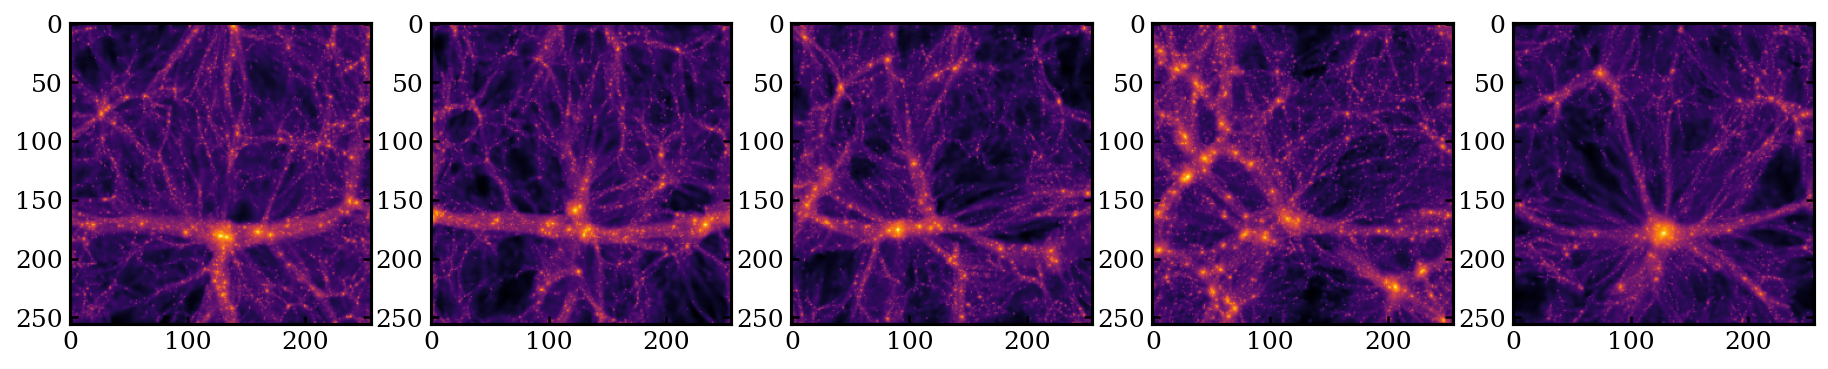

In [8]:
fig, axes = plt.subplots(ncols = 5, nrows = 1, figsize = (15,3))
for i, ax in enumerate(axes.flat):
    im = ax.imshow(preprocessed_imgs[i], cmap = 'inferno')
    
plt.show()


## problem fixed, had a bug w/ the counter
## now it works as intended

## attempted to redo preprocessing to prevent compressing the data

In [9]:
## taking only the first image --> compress to 1000 images:
counter = 0
compressed_preprocessed_imgs = []
for img_index in range(0, len(preprocessed_imgs), 15):
    compressed_preprocessed_imgs.append(preprocessed_imgs[counter])
    counter += 1

print(f"ONLY FIRST IMAGE FROM EACH ARRAY ELEMENT SHAPE: {np.array(compressed_preprocessed_imgs).shape}")

ONLY FIRST IMAGE FROM EACH ARRAY ELEMENT SHAPE: (538, 256, 256)


Min Pixel Value: -2.08 --- Max Pixel Value: 7.32
Particle Mass: 4.49 keV


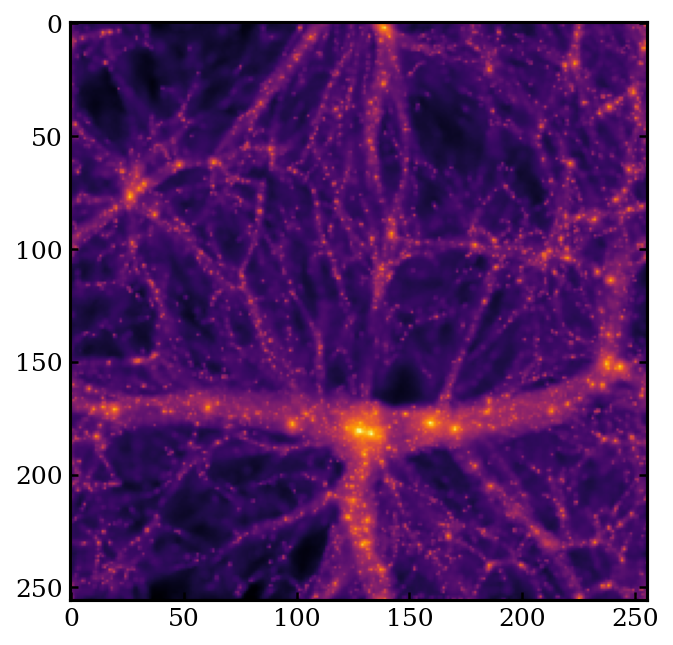

In [10]:
fig, ax = plt.subplots(figsize = (5,5))
index = 0

print(f"Min Pixel Value: {(np.min(preprocessed_imgs[0])):.2f} --- Max Pixel Value: {(np.max(preprocessed_imgs[0])):.2f}")
ax.imshow(compressed_preprocessed_imgs[index], cmap = "inferno")
print(f"Particle Mass: {(1/(WDM_params_test[:, 5][index])):.2f} keV")
plt.show()

## Building the 2-D CNN:

**MODEL BUILDING HELP:** (Some info taken from PHYS139 lectures / GitHub.io page)

"There are four principal components to a CNN: a convolutional layer, a nonlinear activation function, a pooling or downsampling operation, and a fully connected layer for classification."
* Most TensorFlow models start with a Sequential layer, but you don't really need to do anything with this (besides name it if you want...)
* Conv2D --> takes in an integer for filters (first #), a "kernel" size (basically the size of the convolution window), a padding ("valid" = none or "same" = zero_padding), and (optional) activation function to use after convolution. "Once learned the kernels within the convolutional layer can appear as physically intuitive operations on the images such as edge detection filters."
* BatchNormalization --> tries to maintain the mean output close to 0 (stabilizes things)
* Activation --> "As with traditional neural networks, a nonlinear activation function is applied to the individual pixels in the resulting feature maps."
* MaxPooling2D --> "The pooling in the CNN downsamples or subsamples the feature maps. Pooling summarizes values within a region of interest (e.g., a pixel window). The summary can be the average pixel value but more commonly the maximum pixel value is preserved (max pooling) in the downsampling. This pooling of the feature maps reduces the size of the resulting network and makes the network less sensitive to small translations or distortions between images."

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

In [12]:
img_height, img_width = 256, 256

# get the total number of sims and maps:
splits = 15
WDM_params = np.loadtxt("WDM_TNG_params_1000.txt")  # simulations parameters, NOT maps parameters
total_sims, total_maps, num_params = WDM_params.shape[0], WDM_params.shape[0]*splits, WDM_params.shape[1]
params = np.zeros((total_maps, num_params), dtype = np.float32)
for i in range(total_sims):
    for j in range(splits):
        params[i * splits + j] = WDM_params[i]  # filling up the full params array for each individual image/map

print(f"Params Correct Shape if params.shape = (15000, 6) --> params.shape = {params.shape}")

Params Correct Shape if params.shape = (15000, 6) --> params.shape = (15000, 6)


In [13]:
# loading in parameters:
#WDM_params = np.loadtxt('WDM_TNG_params_1000.txt')
#print(WDM_params.shape)
#WDM_param_names = ['OmegaM','sigma8','SNE','SNv','AGN','1/m_WDM']
#minimum = np.array([0.1,  0.6,  0.25,   0.5,    0.25, 0.0625])
#maximum = np.array([0.5,  1.0,  4.00,   2.00,   4.00, 0.5555])
#WDM_params = (WDM_params * (maximum - minimum)) + minimum

In [14]:
import tensorflow as tf
import keras
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization, LeakyReLU, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

In [15]:
## TODO:
## do some rotations, flips, train on maybe all the slices??
## shuffle data, do k-fold validation

In [16]:
## using the hands-on portion from class for guidance:
def test_CNN(input_shape = (256, 256, 1)):

    model = Sequential(name = "test_CNN")
    model.add(Input(shape = input_shape))

    ## conv. block 1:
    model.add(Conv2D(filters = 32, kernel_size = (3, 3), strides = (1, 1), padding = "same", activation = "relu", name = "conv_1"))
    #model.add(BatchNormalization(name = "bn_1"))
    model.add(MaxPooling2D(pool_size = (2, 2), name = "pool_1"))

    ## conv. block 2:
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), strides = (1, 1), padding = "same", activation = "relu", name = "conv_2"))
    #model.add(BatchNormalization(name = "bn_2"))
    model.add(MaxPooling2D(pool_size = (2, 2), name = "pool_2"))

    ## conv. block 3:
    model.add(Conv2D(filters = 128, kernel_size = (3, 3), strides = (1, 1), padding = "same", activation = "relu", name = "conv_3"))
    #model.add(BatchNormalization(name = "bn_3"))
    model.add(MaxPooling2D(pool_size = (2, 2), name = "pool_3"))

    # conv. block 4
    #model.add(layers.Conv2D(filters = 256, kernel_size = (3, 3), strides = (1,1), padding = "same", activation = "relu", name = "conv_4"))
    #model.add(MaxPooling2D(pool_size = (2, 2), name = "pool_4"))


    ## output layers
    #model.add(layers.GlobalAveragePooling2D(name = "global_pooling"))
    model.add(Dense(128, activation = 'relu', name = "dense_1"))
    #model.add(Dropout(0.2))
    model.add(Dense(1, activation = None, name = "output"))
    
    return model

In [17]:
test_model = test_CNN()
test_model.summary()

Model: "test_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                      │ (None, 256, 256, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_1 (MaxPooling2D)                │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_2 (Conv2D)                      │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_2 (MaxPooling2D)                │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_3 (Conv2D)                      │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_3 (MaxPooling2D)                │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32, 32, 128)         │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 32, 32, 1)           │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 109,313 (427.00 KB)

 Trainable params: 109,313 (427.00 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
## FILTER OUT OUTLIERS HERE
inv_WDM_mass = np.loadtxt('WDM_TNG_params_1000.txt')[:538]  # make this cutoff general later, for now it's just cutting the 0's from before...
WDM_mass_true = np.array(1/inv_WDM_mass[:, 5])

X = np.array(compressed_preprocessed_imgs)[WDM_mass_true < 30]
y = WDM_mass_true[WDM_mass_true < 30]

# splitting and shuffling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, shuffle = True)

#y_mean = y_train.mean()
#y_std  = y_train.std()

#y_train_scaled = (y_train - y_mean) / y_std
#y_test_scaled  = (y_test - y_mean) / y_std

#print("y_train_log min/max:", y_train.min(), y_train.max())
#print("y_train_log mean/std:", y_train.mean(), y_train.std())

#print("y_train_log min/max:", y_train_scaled.min(), y_train_scaled.max())
#print("y_train_log mean/std:", y_train_scaled.mean(), y_train_scaled.std())

#print("X train min/max/mean/std:", X_train.min(), X_train.max(), X_train.mean(), X_train.std())

In [19]:
## predictions before training
#print("Before training:", test_model.predict(X[:1]))

In [20]:
print("y_train_scaled min/max:", y_train.min(), y_train.max())
print("y_train_scaled first 15:", y_train[:15])

y_train_scaled min/max: 1.003920308805887 28.46002789082733
y_train_scaled first 15: [ 9.13625815  1.04717524  8.22206144  1.37000189  3.33849688  1.36389736
 28.46002789  1.0152511   1.52645188  4.65848636  5.05142349 13.72269184
  1.06199277  2.41813407  1.72442335]


In [22]:
# training parameters:

# use for preprocessing the same way as in the paper:
#normalized_images_use_formatted = np.log10(normalized_images_use)
#mean = np.mean(normalized_images_use_formatted)
#std = np.std(normalized_images_use_formatted)
#normalized_images_use_formatted = (normalized_images_use_formatted - mean) / std

## n_splits = 5
#kf = KFold(n_splits = n_splits, shuffle = True, random_state = 42)

## TRAINING:
early_stopping = [tf.keras.callbacks.EarlyStopping(monitor = 'loss', min_delta = 1e-4, patience = 15, restore_best_weights = True)]
#lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'loss', factor = 0.5, patience = 3, min_lr = 5e-7, verbose = 1)

test_model.compile(optimizer = keras.optimizers.Adam(learning_rate = 3e-4), loss = 'mse', metrics = ['mae'])
history = test_model.fit(X_train, y_train, epochs = 250, batch_size = 16, callbacks = [early_stopping], shuffle = True, validation_data = (X_test, y_test), verbose = 1)

Epoch 1/250
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 237ms/step - loss: 19.8796 - mae: 2.7880 - val_loss: 9.2225 - val_mae: 2.1653
Epoch 2/250
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 231ms/step - loss: 19.5866 - mae: 2.7636 - val_loss: 8.8797 - val_mae: 1.9911
Epoch 3/250
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 233ms/step - loss: 20.0919 - mae: 2.7187 - val_loss: 9.1138 - val_mae: 2.1210
Epoch 4/250
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 228ms/step - loss: 19.5143 - mae: 2.6528 - val_loss: 9.3667 - val_mae: 2.2296
Epoch 5/250
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 238ms/step - loss: 19.4787 - mae: 2.7504 - val_loss: 9.4271 - val_mae: 2.2544
Epoch 6/250
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 237ms/step - loss: 19.4556 - mae: 2.7329 - val_loss: 9.4665 - val_mae: 2.2709
Epoch 7/250
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 235ms/step - loss: 19.4283 - mae: 2.8034 - val_loss: 9.0540 - val_mae: 2.1015
Epoch 8/250
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 234ms/step - loss: 19.5230 - mae: 2.7805 - val_loss: 8.8733 - val_mae: 2.0029
Epoch 9/250
26/26 ━━━━━━━━━━━━━━━━━━━━ 6


KeyboardInterrupt



In [23]:
test_loss, test_mae = test_model.evaluate(X_test, y_test)
print("Final Test MSE:", test_loss)
print("Final Test MAE:", test_mae)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 9.3490 - mae: 2.2587  
Final Test MSE: 9.348979949951172
Final Test MAE: 2.2586827278137207


In [24]:
## after training prediction of the same plot
print("After training:", test_model.predict(X[:1]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
After training: [[[[3.9775221]
   [4.05583  ]
   [4.0370975]
   ...
   [2.7426045]
   [3.15756  ]
   [3.898072 ]]

  [[4.392431 ]
   [4.3650303]
   [4.0940504]
   ...
   [2.8762476]
   [3.4183602]
   [4.016588 ]]

  [[3.7946723]
   [4.4504166]
   [4.2743435]
   ...
   [2.916815 ]
   [3.2189527]
   [3.4272153]]

  ...

  [[3.9589784]
   [4.690662 ]
   [4.476819 ]
   ...
   [3.7776997]
   [3.9190848]
   [3.7644372]]

  [[3.6135857]
   [4.0662045]
   [4.118048 ]
   ...
   [4.04332  ]
   [3.6158185]
   [3.1084507]]

  [[3.3751023]
   [3.572787 ]
   [3.4872518]
   ...
   [4.1831403]
   [3.5712793]
   [3.1131332]]]]


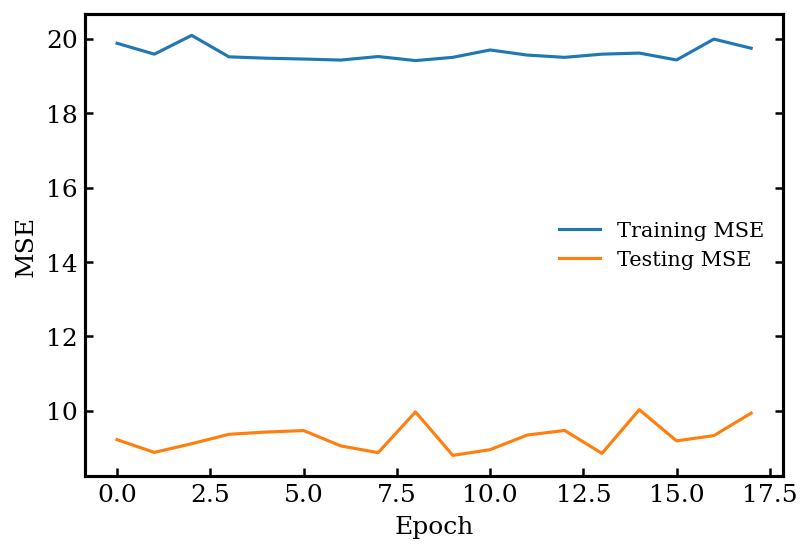

In [25]:
## plotting training and testing loss

fig, ax = plt.subplots(figsize = (6,4))

## getting metrics
train_loss_mse = test_model.history.history['loss']
val_loss_mse = test_model.history.history['val_loss']

ax.plot(train_loss_mse, color = "tab:blue", label = "Training MSE")
ax.plot(val_loss_mse, color = "tab:orange", label = "Testing MSE")
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE')
ax.legend()

#plt.savefig("train + test error.png")
plt.show()

In [26]:
y_pred = test_model.predict(X).flatten()

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step


In [29]:
## ANALYSIS:
for index, val in enumerate(WDM_mass_true[WDM_mass_true < 30]):
    if val <= 3.25:
        print(f" !!! {index}, True Value: {val}, Prediction: {y_pred[index]}, Error: {((val - y_pred[index]) / val):.2f} --> Error should be LOW")
    elif val > 3.25:
        print(f" *** {index}, True Value: {val}, Prediction: {y_pred[index]}, Error: {((val - y_pred[index]) / val):.2f} --> Error should be HIGH")

 !!! 0, True Value: 3.079405551552328, Prediction: 3.9775218963623047, Error: -0.29 --> Error should be LOW
 !!! 1, True Value: 1.0644027529712803, Prediction: 4.0558295249938965, Error: -2.81 --> Error should be LOW
 !!! 2, True Value: 1.3666803334700013, Prediction: 4.037097454071045, Error: -1.95 --> Error should be LOW
 *** 3, True Value: 10.265570303758226, Prediction: 4.089349269866943, Error: 0.60 --> Error should be HIGH
 !!! 4, True Value: 2.42788572427473, Prediction: 4.216009616851807, Error: -0.74 --> Error should be LOW
 !!! 5, True Value: 1.2622087137840765, Prediction: 4.073805809020996, Error: -2.23 --> Error should be LOW
 !!! 6, True Value: 1.9842726549369694, Prediction: 3.814749002456665, Error: -0.92 --> Error should be LOW
 *** 7, True Value: 7.3909283745131225, Prediction: 3.714365243911743, Error: 0.50 --> Error should be HIGH
 !!! 8, True Value: 1.5297981737269404, Prediction: 3.7845635414123535, Error: -1.47 --> Error should be LOW
 !!! 9, True Value: 1.082350

ValueError: x and y must be the same size

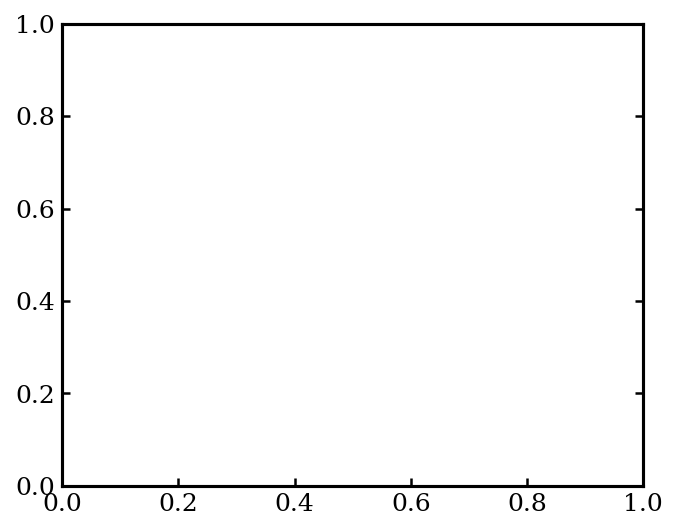

In [32]:
plt.scatter(y, y_pred, s = 6)
plt.plot([min(y), max(y)], [min(y), max(y)], 'r--')
plt.xlabel("True Mass")
plt.ylabel("Predicted Mass")
plt.title("True vs Predicted Mass")
#plt.savefig("True vs Predicted Mass")
plt.show()